# Product Recommendation Project
---

## BUSINESS PROBLEM
---
Providing product recommendations to users based on their shopping basket analysis using Association Rule Based Recommendation Systems.

## DATASET STORY
---

This dataset, called 'Online Retail,' tracks the sales of a UK-based online store from December 1, 2009, to December 9, 2011.
This company's product catalog includes gift items.

## FEATURES
---

- **InvoiceNo:** Invoice Number - If this code starts with 'C', it means the transaction was canceled.
- **StockCode:** Product Code - A unique number for each product.
- **Description:** Product Name - Quantity - Quantity of the product
- **Quantity:** Quantity of the product - Indicates how many of the products were sold in the invoices.
- **InvoiceDate:** Invoice Date
- **UnitPrice:** Unit Price of the Invoice (in British Pounds)
- **CustomerID:** Unique Customer Number
- **Country:** Country Name

## STEPS
---
### Step 1: Explorative Data Analysis
 - 1.1:
 
### Step 2: Data Preprocessing
 - 2.1: 
 
### Step 3: Preparing ARL Data Structure
 - 3.1: 
 
### Step 4: Association Rule Learning
 - 4.1: 
 
### Step 5: Script Preparation for the Study

### Step 6: Providing Product Recommendations to Users in the Basket Stage

---

### *Libraries and Settings*
---

In [1]:
# !pip install mlxtend 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend. frequent_patterns import apriori, association_rules
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
#pd.set_option('display.max_rows', None)

---
# Explorative Data Analysis
---

In [2]:
online_retail = pd.read_excel("/kaggle/input/online-retail-ii-for-arl/online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [3]:
df = online_retail.copy()
df.head()

Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   2.55      17850.0  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   2.75      17850.0  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom

In [4]:
df.describe().T
df["Country"].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8558
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [5]:
df.shape

(541910, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

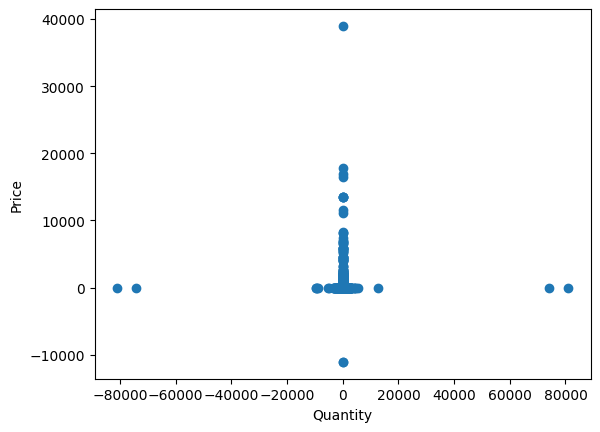

In [8]:
plt.scatter(df["Quantity"], df["Price"])
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.show();

### Comments:
- As we see there are minus values in 'Quantity' and 'Price' (most prob caused by 'C' coded products / cancelled products) which they are expected to be min 0.
- Also, we observe that the range between 75% and max values are extremely high in compare to 50% and 75% and it is required to be corrected.
- There are some missing values in 'Description' and 'Customer ID'

---
# Data Preprocessing
---

We define a couple of functions to prepare our data for ARL.

In [9]:
def outliers_thresholds_finder(dataframe, col_name, lower_threshold= 0.25, upper_threshold=0.75):
    q1 = dataframe[col_name].quantile(lower_threshold)
    q3 = dataframe[col_name].quantile(upper_threshold)
    IQR = q3 - q1
    low_limit = q1 - 1.5 * IQR
    up_limit = q3 + 1.5 * IQR
    return low_limit, up_limit

def winsorize(dataframe, col_name, lower_threshold= 0.25, upper_threshold=0.75):
    low_limit, up_limit = outliers_thresholds_finder(dataframe, col_name, lower_threshold, upper_threshold)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit
    return dataframe

def online_retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe[dataframe["Invoice"].apply(lambda x: "C" not in str(x))]
    dataframe = dataframe[dataframe["Price"] > 0]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = winsorize(dataframe, "Price", 0.01, 0.99)
    dataframe = winsorize(dataframe, "Quantity", 0.01, 0.99)
    return dataframe

In [10]:
df = online_retail_data_prep(df)
df.describe().T

count                           mean                  min                  25%                  50%                  75%                  max          std
Quantity     397885.0                       11.83077                  1.0                  2.0                  6.0                 12.0                298.5    25.523052
InvoiceDate    397885  2011-07-10 23:41:56.419316992  2010-12-01 08:26:00  2011-04-07 11:12:00  2011-07-31 14:39:00  2011-10-20 14:33:00  2011-12-09 12:50:00          NaN
Price        397885.0                       2.893492                0.001                 1.25                 1.95                 3.75                37.06     3.227175
Customer ID  397885.0                   15294.416882              12346.0              13969.0              15159.0              16795.0              18287.0  1713.144421

In [11]:
df.shape

(397885, 8)

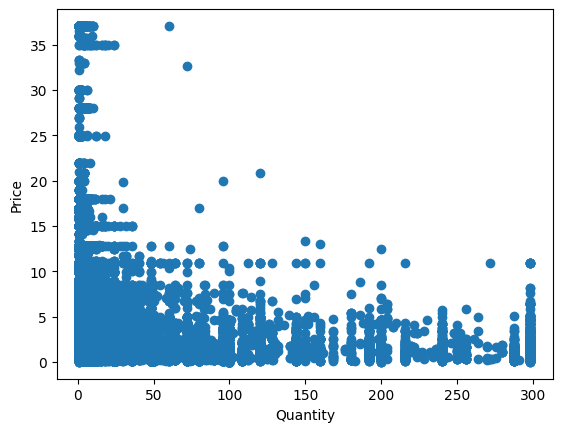

In [12]:
plt.scatter(df["Quantity"], df["Price"])
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.show();

### Comments:
- As dataset is big enough, all missing values are dropped.
- Invoices starting with 'C'(cancelled) are dropped.
- Observations with minus values in 'Price' and 'Quantity' are deleted.
- Outliers are winsorized using 0.01 and 0.99 thresholds.

---
# Preparing ARL Data Structure (Invoice-Product Matrix)
---

To create an Invoice-Product matrix for Association Rule Learning (ARL), where invoices are represented in rows and products in columns, we need to group them by summing the quantities for each invoice while considering each product (listed under 'Description').

**Note:** For demonstration purposes, 'Description' / Product names are used in columns. However, in regular circumstances, it is advisable to utilize product IDs or similar numerical values to represent products, particularly when considering CPU performance.

In [13]:
df_groupby = df.groupby(["Invoice","Description"]).agg({"Quantity":"sum"})
df_groupby

Quantity
Invoice Description                                  
536365  CREAM CUPID HEARTS COAT HANGER            8.0
        GLASS STAR FROSTED T-LIGHT HOLDER         6.0
        KNITTED UNION FLAG HOT WATER BOTTLE       6.0
        RED WOOLLY HOTTIE WHITE HEART.            6.0
        SET 7 BABUSHKA NESTING BOXES              2.0
...                                               ...
581587  PACK OF 20 SPACEBOY NAPKINS              12.0
        PLASTERS IN TIN CIRCUS PARADE            12.0
        PLASTERS IN TIN STRONGMAN                12.0
        POSTAGE                                   1.0
        SPACEBOY LUNCH BOX                       12.0

[387739 rows x 1 columns]

In [14]:
df_arl = df_groupby.reset_index().pivot_table("Quantity","Invoice","Description")
df_arl

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK   I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY   OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET   TOADSTOOL BEDSIDE LIGHT    TRELLIS COAT RACK  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  12 PENCILS TALL TUBE POSY  12 PENCILS TALL TUBE RED RETROSPOT  12 PENCILS TALL TUBE SKULLS  12 PENCILS TALL TUBE WOODLAND  12 PINK HEN+CHICKS IN BASKET  12 PINK ROSE PEG PLACE SETTINGS  12 RED ROSE PEG PLACE SETTINGS  15 PINK FLUFFY CHICKS IN BOX  15CM CHRISTMAS GLASS BALL 20 LIGHTS  16 PC CUTLERY SET PANTRY DESIGN  16 PIECE CUTLERY SET PANTRY DESIGN  18PC WOODEN CUTLERY SET DISPOSABLE  2 DAISIES HAIR COMB  2 PICTURE BOOK EGGS EASTER BUNNY  2 PICTURE BOOK EGGS EASTER CHICKS  2 PICTURE BOOK EGGS EASTER DUCKS  20 DOLLY PEGS RETROSPOT  200 BENDY SKULL STRAWS  200 RED + WHITE BENDY STRAWS  3 BIRDS CANVAS SCREEN  3 BLACK CATS W HEARTS BLANK CARD  3 DRAWER ANTIQUE WHITE WOOD CABINET  3 GARDENIA MORRIS BOXED CANDLES  3 HEARTS HANGING DECORATION RUSTIC  3 HOOK HANGER MAGIC GARDEN  3 HOOK PHOTO SHELF ANTIQUE WHITE  3 PIECE SPACEBOY COOKIE CUTTER SET  3 PINK HEN+CHICKS IN BASKET  3 RAFFIA RIBBONS 50'S CHRISTMAS   3 RAFFIA RIBBONS VINTAGE CHRISTMAS  3 ROSE MORRIS BOXED CANDLES  3 STRIPEY MICE FELTCRAFT  3 TIER CAKE TIN GREEN AND CREAM  3 TIER CAKE TIN RED AND CREAM  3 TIER SWEETHEART GARDEN SHELF  3 TRADITIONAL COOKIE CUTTERS  SET  3 TRADITIONAl BISCUIT CUTTERS  SET  3 WHITE CHOC MORRIS BOXED CANDLES  3 WICK CHRISTMAS BRIAR CANDLE   36 DOILIES DOLLY GIRL  36 DOILIES VINTAGE CHRISTMAS  36 FOIL HEART CAKE CASES  36 FOIL STAR CAKE CASES   36 PENCILS TUBE POSY  36 PENCILS TUBE RED RETROSPOT  36 PENCILS TUBE SKULLS  36 PENCILS TUBE WOODLAND  3D CHRISTMAS STAMPS STICKERS   3D DOG PICTURE PLAYING CARDS  3D HEARTS  HONEYCOMB PAPER GARLAND  3D SHEET OF CAT STICKERS  3D SHEET OF DOG STICKERS  3D TRADITIONAL CHRISTMAS STICKERS  3D VINTAGE CHRISTMAS STICKERS   4 BLUE DINNER CANDLES SILVER FLOCK  4 BURGUNDY WINE DINNER CANDLES  4 IVORY DINNER CANDLES SILVER FLOCK  4 LAVENDER BOTANICAL DINNER CANDLES  4 LILY  BOTANICAL DINNER CANDLES  4 PEAR BOTANICAL DINNER CANDLES  4 PINK DINNER CANDLE SILVER FLOCK  4 PINK FLOCK CHRISTMAS BALLS  4 ROSE PINK DINNER CANDLES  4 SKY BLUE DINNER CANDLES  4 TRADITIONAL SPINNING TOPS  4 VANILLA BOTANICAL CANDLES  4 WILDFLOWER BOTANICAL CANDLES  5 HOOK HANGER MAGIC TOADSTOOL  5 HOOK HANGER RED MAGIC TOADSTOOL  5 STRAND GLASS NECKLACE AMBER  5 STRAND GLASS NECKLACE AMETHYST  5 STRAND GLASS NECKLACE BLACK  5 STRAND GLASS NECKLACE CRYSTAL  50'S CHRISTMAS PAPER GIFT BAG  50CM METAL STRING WITH  7 CLIPS  6 CHOCOLATE LOVE HEART T-LIGHTS  6 EGG HOUSE PAINTED WOOD  6 GIFT TAGS 50'S CHRISTMAS   6 GIFT TAGS VINTAGE CHRISTMAS   6 RIBBONS ELEGANT CHRISTMAS   6 RIBBONS EMPIRE    6 RIBBONS RUSTIC CHARM  6 RIBBONS SHIMMERING PINKS   6 ROCKET BALLOONS   60 CAKE CASES DOLLY GIRL DESIGN  60 CAKE CASES VINTAGE CHRISTMAS  60 GOLD AND SILVER FAIRY CAKE CASES  60 TEATIME FAIRY CAKE CASES  6PC WOOD PLATE SET DISPOSABLE  70'S ALPHABET WALL ART  72 CAKE CASES VINTAGE CHRISTMAS  72 SWEETHEART FAIRY CAKE CASES  75 BLACK PETIT FOUR CASES  75 GREEN FAIRY CAKE CASES  75 GREEN PETIT FOUR CASES  A PRETTY THANK YOU CARD  A4 WALL TIDY BLUE OFFICE  A4 WALL TIDY RED FLOWERS  ABC TREASURE BOOK BOX   ABSTRACT CIRCLE JOURNAL   ABSTRACT CIRCLES POCKET BOOK  ABSTRACT CIRCLES SKETCHBOOK   ACRYLIC GEOMETRIC LAMP  ACRYLIC HANGING JEWEL,BLUE  ACRYLIC HANGING JEWEL,PINK  ACRYLIC JEWEL ANGEL,PINK  ACRYLIC JEWEL ICICLE, BLUE  ACRYLIC JEWEL ICICLE, PINK  ACRYLIC JEWEL SNOWFLAKE, PINK  ACRYLIC JEWEL SNOWFLAKE,PINK  ADULT APRON APPLE DELIGHT 

Now, we need to convert each quantity (frequency) in the Invoice-Product Matrix to a binary form.

In [15]:
df_arl = df_arl.applymap(lambda x: 1 if x > 0 else 0)
df_arl

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK   I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY   OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET   TOADSTOOL BEDSIDE LIGHT    TRELLIS COAT RACK  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  12 PENCILS TALL TUBE POSY  12 PENCILS TALL TUBE RED RETROSPOT  12 PENCILS TALL TUBE SKULLS  12 PENCILS TALL TUBE WOODLAND  12 PINK HEN+CHICKS IN BASKET  12 PINK ROSE PEG PLACE SETTINGS  12 RED ROSE PEG PLACE SETTINGS  15 PINK FLUFFY CHICKS IN BOX  15CM CHRISTMAS GLASS BALL 20 LIGHTS  16 PC CUTLERY SET PANTRY DESIGN  16 PIECE CUTLERY SET PANTRY DESIGN  18PC WOODEN CUTLERY SET DISPOSABLE  2 DAISIES HAIR COMB  2 PICTURE BOOK EGGS EASTER BUNNY  2 PICTURE BOOK EGGS EASTER CHICKS  2 PICTURE BOOK EGGS EASTER DUCKS  20 DOLLY PEGS RETROSPOT  200 BENDY SKULL STRAWS  200 RED + WHITE BENDY STRAWS  3 BIRDS CANVAS SCREEN  3 BLACK CATS W HEARTS BLANK CARD  3 DRAWER ANTIQUE WHITE WOOD CABINET  3 GARDENIA MORRIS BOXED CANDLES  3 HEARTS HANGING DECORATION RUSTIC  3 HOOK HANGER MAGIC GARDEN  3 HOOK PHOTO SHELF ANTIQUE WHITE  3 PIECE SPACEBOY COOKIE CUTTER SET  3 PINK HEN+CHICKS IN BASKET  3 RAFFIA RIBBONS 50'S CHRISTMAS   3 RAFFIA RIBBONS VINTAGE CHRISTMAS  3 ROSE MORRIS BOXED CANDLES  3 STRIPEY MICE FELTCRAFT  3 TIER CAKE TIN GREEN AND CREAM  3 TIER CAKE TIN RED AND CREAM  3 TIER SWEETHEART GARDEN SHELF  3 TRADITIONAL COOKIE CUTTERS  SET  3 TRADITIONAl BISCUIT CUTTERS  SET  3 WHITE CHOC MORRIS BOXED CANDLES  3 WICK CHRISTMAS BRIAR CANDLE   36 DOILIES DOLLY GIRL  36 DOILIES VINTAGE CHRISTMAS  36 FOIL HEART CAKE CASES  36 FOIL STAR CAKE CASES   36 PENCILS TUBE POSY  36 PENCILS TUBE RED RETROSPOT  36 PENCILS TUBE SKULLS  36 PENCILS TUBE WOODLAND  3D CHRISTMAS STAMPS STICKERS   3D DOG PICTURE PLAYING CARDS  3D HEARTS  HONEYCOMB PAPER GARLAND  3D SHEET OF CAT STICKERS  3D SHEET OF DOG STICKERS  3D TRADITIONAL CHRISTMAS STICKERS  3D VINTAGE CHRISTMAS STICKERS   4 BLUE DINNER CANDLES SILVER FLOCK  4 BURGUNDY WINE DINNER CANDLES  4 IVORY DINNER CANDLES SILVER FLOCK  4 LAVENDER BOTANICAL DINNER CANDLES  4 LILY  BOTANICAL DINNER CANDLES  4 PEAR BOTANICAL DINNER CANDLES  4 PINK DINNER CANDLE SILVER FLOCK  4 PINK FLOCK CHRISTMAS BALLS  4 ROSE PINK DINNER CANDLES  4 SKY BLUE DINNER CANDLES  4 TRADITIONAL SPINNING TOPS  4 VANILLA BOTANICAL CANDLES  4 WILDFLOWER BOTANICAL CANDLES  5 HOOK HANGER MAGIC TOADSTOOL  5 HOOK HANGER RED MAGIC TOADSTOOL  5 STRAND GLASS NECKLACE AMBER  5 STRAND GLASS NECKLACE AMETHYST  5 STRAND GLASS NECKLACE BLACK  5 STRAND GLASS NECKLACE CRYSTAL  50'S CHRISTMAS PAPER GIFT BAG  50CM METAL STRING WITH  7 CLIPS  6 CHOCOLATE LOVE HEART T-LIGHTS  6 EGG HOUSE PAINTED WOOD  6 GIFT TAGS 50'S CHRISTMAS   6 GIFT TAGS VINTAGE CHRISTMAS   6 RIBBONS ELEGANT CHRISTMAS   6 RIBBONS EMPIRE    6 RIBBONS RUSTIC CHARM  6 RIBBONS SHIMMERING PINKS   6 ROCKET BALLOONS   60 CAKE CASES DOLLY GIRL DESIGN  60 CAKE CASES VINTAGE CHRISTMAS  60 GOLD AND SILVER FAIRY CAKE CASES  60 TEATIME FAIRY CAKE CASES  6PC WOOD PLATE SET DISPOSABLE  70'S ALPHABET WALL ART  72 CAKE CASES VINTAGE CHRISTMAS  72 SWEETHEART FAIRY CAKE CASES  75 BLACK PETIT FOUR CASES  75 GREEN FAIRY CAKE CASES  75 GREEN PETIT FOUR CASES  A PRETTY THANK YOU CARD  A4 WALL TIDY BLUE OFFICE  A4 WALL TIDY RED FLOWERS  ABC TREASURE BOOK BOX   ABSTRACT CIRCLE JOURNAL   ABSTRACT CIRCLES POCKET BOOK  ABSTRACT CIRCLES SKETCHBOOK   ACRYLIC GEOMETRIC LAMP  ACRYLIC HANGING JEWEL,BLUE  ACRYLIC HANGING JEWEL,PINK  ACRYLIC JEWEL ANGEL,PINK  ACRYLIC JEWEL ICICLE, BLUE  ACRYLIC JEWEL ICICLE, PINK  ACRYLIC JEWEL SNOWFLAKE, PINK  ACRYLIC JEWEL SNOWFLAKE,PINK  ADULT APRON APPLE DELIGHT 

---
# Association Rule Learning
---

In [16]:
country = "Austria"

df_at = df[df["Country"] == country]
df_arl = df_at.groupby(["Invoice","StockCode"]).agg({"Quantity":"sum"}) \
              .reset_index().pivot_table("Quantity","Invoice","StockCode") \
              .applymap(lambda x: 1 if x > 0 else 0)
df_arl

StockCode  20679  21166  21181  21260  21430  21770  21906  22366  22382  22423  22488  22494  22629  22630  22662  22697  22698  22699  22722  22993  23049  23050  23051  23052  23053  23054  23178  23179  15056BL  15056N  15056P  84971S
Invoice                                                                                                                                                                                                                                       
550201         1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1      1        1       1       1       1

In [ ]:
freq_itemsets = apriori(df_arl, 
                        min_support=0.01,
                        use_colnames=True)
freq_itemsets

In [ ]:
rules = association_rules(freq_itemsets, 
                          metric="support", 
                          min_threshold=0.01)

rules

---
# Script Preparation for the Study
---

---
# Providing Product Recommendations to Users in the Basket Stage
---